In [1]:
from input import *
locals().update(params_value_kragarm)

# Modelle mit Drehfedern

## Nachrechnung Kragarm

Um das Verhalten der FE-Programme mit Drehfedern einzuschätzen, werden Verformungen an einem fiktivem Beispiel bestimmt. Dargestellt ist der Kragarm in @fig-kragarm-feder. Die Verformung an der Stelle $w$ wird  händisch mittels Arbeitsgleichung und mit dem FE-Programm bestimmt. Es sollen nicht-lineare Federsteifigikeiten berücksichtigt werden können.

![Statisches System des Kragarms](../imgs/Kragarm_system_Feder.svg){#fig-kragarm-feder}


Die Parameter in der @tbl-parameters-kragarm dienen als Berechnungsgrundlagen. Beschrieben sind die Abmessungen und Materialeigenschaften, sowie die Beiden Laststufen $F_1$ und $F_2$ wie auch die  Federsteifigkeiten $k_1$ und $k_2$. Die Laststufen sind so gewählt, dass das nicht-lineare Verhalten der Drehfeder zu tragen kommt.

In [2]:
#| label: tbl-parameters-kragarm
#| tbl-cap: "Berechnungsparameter des Kragarms"

dict_to_table(params_kragarm)


|  Parameter  | ​  |
|---|---|
| $E = \frac{10000 \text{N}}{\text{mm}^{2}}$ | $F_{1} = - 10000 \text{N}$ |
| $F_{2} = - 21500 \text{N}$ | $b = 200 \text{mm}$ |
| $h = 400 \text{mm}$ | $k_{1} = \frac{100000 \text{N}}{\text{m}}$ |
| $k_{2} = \frac{10000 \text{N}}{\text{m}}$ | $l_{Kragarm} = 5 \text{m}$ |
| $z = 320 \text{mm}$ | ​  |


Der Querschnitt ist in @fig-qs-kragarm aufgezeigt.

![Fiktiver Querschnitt des Kragarms mit linear-elastischem Materialverhalten](../imgs/Kragarm_querschnitt.svg){#fig-qs-kragarm}

Die Entsprechende Federcharakteristik ist in @fig-springcharacteristic zu sehen.


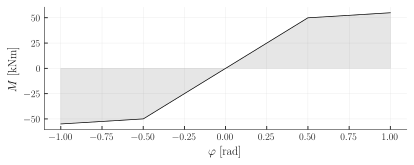

In [3]:
#| label: fig-springcharacteristic
#| fig-cap: "Charakteristik der Drehfeder"

def M_phi_spring(phi:np.array, k_phi1, k_phi2):
    phi_1, phi_2, phi_3, phi_4 = np.array_split(phi,4)
    M_phi_1 = phi_3 * k_phi1
    M_phi_2 = M_phi_1[-1] + phi_3 * k_phi2 
    M_phi_3 = np.flip(-M_phi_1)
    M_phi_4 = np.flip(-M_phi_2)

    M_phi = np.concatenate((M_phi_4, M_phi_3, M_phi_1, M_phi_2))
    return M_phi

# Arrays
Phi_spring_array = np.linspace(-1,1,1000)
M_phi_array = M_phi_spring(Phi_spring_array, k_1, k_2)



plt.plot(Phi_spring_array, M_phi_array/10**3, color='black')
plt.fill_between(Phi_spring_array, M_phi_array/10**3, color='black', alpha = 0.1)

plt.xlabel('$\\varphi$ [rad]')
plt.ylabel('$M$ [kNm]')
plt.show()


### Biegeverformung

Apriori werden die Biegeverformungen mittels der Differentialgleichung für reine Biegeträger ermittelt. Dabei wird die Drehfeder vernachlässigt. Das statische System, gezeigt in @fig-kragarm-sys führt zu den Zustandslinien der Schnittgrössen in der @fig-sk-kragarmF1.


![Statisches System des Kragarms](../imgs/Kragarm_System.svg){#fig-kragarm-sys}

In [4]:
# GEOMETRY System
x_array = np.linspace(0,l_Kragarm, 500)
q_array = np.zeros(len(x_array))
I = h**3 * b /12

def V_x(c, q_x, x):
    q_integrated = integrate.cumulative_trapezoid(q_x, x, initial=0)
    return -q_integrated + c[0]

def M_x(c, q_x, x):
    V_x_calc = V_x(c, q_x, x)
    V_integrated = integrate.cumulative_trapezoid(V_x_calc, x, initial=0)
    return V_integrated + c[1]

def Phi_x(c, q_x, x, E, I):
    M_x_calc = M_x(c, q_x, x)
    M_integrated = integrate.cumulative_trapezoid(M_x_calc, x, initial=0)
    return 1/(E*I)*M_integrated + c[2]

def w_x(c, q_x, x, E, I):
    Phi_x_calc = Phi_x(c, q_x, x, E, I)
    Phi_integrated = -integrate.cumulative_trapezoid(Phi_x_calc, x, initial=0)
    return Phi_integrated+c[3]

# Define the equations to solve

def calc_internal_forces(F:float):
    def initial_conditions(c):
        return [V_x(c, q_array, x_array)[0]+F,  # Shear force at the start is F
                M_x(c, q_array, x_array)[-1],  # Bending moment at the end is 0
                Phi_x(c, q_array, x_array, E, I)[0],  # Angle or rotation at the start is 0
                w_x(c, q_array, x_array, E, I)[0]]  # Displacement at the start is 0

    # Solve for the integration constants
    integration_constants = fsolve(initial_conditions, [1, 1, 1, 1])


    V_x_array = V_x(integration_constants, q_array, x_array)
    M_x_array = M_x(integration_constants, q_array, x_array)
    Phi_x_array = Phi_x(integration_constants, q_array, x_array, E, I)
    w_x_array = w_x(integration_constants, q_array, x_array, E, I)

    return V_x_array, M_x_array, Phi_x_array, w_x_array

internal_forces_F1 = calc_internal_forces(F1)
internal_forces_F2 = calc_internal_forces(F2)

In [5]:
def plot_inner_forces(V:np.array, M:np.array, Phi:np.array, w:np.array, x:np.array, kinematic=True, colors:list=['green', 'orange', 'red', 'blue']):

    fig, axs = plt.subplots(2, 2, figsize=(6,4))
       
    # Plot V_x_array
    axs[0, 0].plot(x, V/1000, color=colors[0], alpha=0.5)
    axs[0, 0].fill_between(x, V/1000, color=colors[0], alpha=0.1)
    axs[0, 0].plot(x, x * 0, color='black')
    axs[0, 0].set_xlabel('$x$ [m]')
    axs[0, 0].set_ylabel('$V_x$ [kN]')

    # Plot M_x_array
    axs[0, 1].plot(x, M/10**3, color=colors[1], alpha=0.5)
    axs[0, 1].fill_between(x, M/10**3, color=colors[1], alpha=0.1)
    axs[0, 1].plot(x, x * 0, color='black')
    axs[0, 1].invert_yaxis()  # Invert the y-axis

    axs[0, 1].set_xlabel('$x$ [m]')
    axs[0, 1].set_ylabel('$M$ [kNm]')

    # Plot Phi_x_array
    axs[1, 0].plot(x, Phi, color=colors[2], alpha=0.5)
    axs[1, 0].fill_between(x, Phi, color=colors[2], alpha=0.1)
    axs[1, 0].plot(x, x * 0, color='black')
    axs[1, 0].set_xlabel('$x$ [m]')
    # axs[1, 0].set_ylim(0,1)
    axs[1, 0].set_ylabel('$\\varphi$ [-]')

    # Plot w_x_array
    axs[1, 1].plot(x, w * 1000, color=colors[3], alpha=0.5)
    axs[1, 1].fill_between(x, w * 1000, color=colors[3], alpha=0.1)
    axs[1, 1].plot(x, x * 0, color='black')
    axs[1, 1].invert_yaxis()  # Invert the y-axis
    axs[1, 1].set_xlabel('$x$ [m]')
    axs[1, 1].set_ylabel('$w$ [mm]')

    if kinematic == False:
        fig.delaxes(axs[1,1])
        fig.delaxes(axs[1,0])

    plt.tight_layout()
    plt.show()

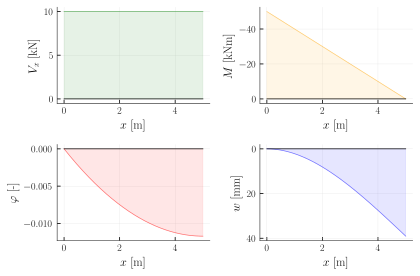

In [6]:
#| label: fig-sk-kragarmF1
#| fig-cap: "Schnittkräfte des Systems aus @fig-kragarm-sys für die Last $F_1$"

plot_inner_forces(*internal_forces_F1, x_array, kinematic=True)


In [7]:
w_max_hand = round(-F1*l_Kragarm**3 / (3*E*I), 5)
w_bending_F1 = round(internal_forces_F1[-1][-1],5)

display_eq('w_Bending,F1', unit.convert_to(w_bending_F1*unit.meter, unit.mm))
assert w_max_hand==w_bending_F1, 'Handcalculation shows differences'

w_Bending,F1 = 39.06⋅millimeter

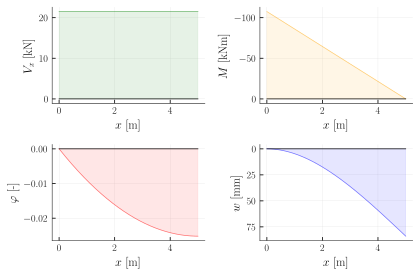

In [8]:
#| label: fig-sk-kragarm-F2
#| fig-cap: "Schnittkräfte des Systems aus @fig-kragarm-sys für die Last $F2$"

plot_inner_forces(*internal_forces_F2, x_array)

In [9]:
w_bending_F2 = round(internal_forces_F2[-1][-1],5)


display_eq('w_Bending,F_2', unit.convert_to(w_bending_F2*unit.meter, unit.mm))


w_Bending,F_2 = 83.98⋅millimeter

### Verformung der Drehfeder

Die Verformung aus der Drehfeder bedingt das Biegemoment des realen und des fiktiven Systems an der Stelle der Drehfeder, sowie die Federkonstante $k_\varphi$. Das System is in @fig-kragarm-sys-virtuell gezeigt. 

![Statisches System des Kragarms im virtuellen Kräftezustand](../imgs/Kragarm_system_feder_virtuell.svg){#fig-kragarm-sys-virtuell}

Die entsprechenden Verläufe der Querkraft und des Biegemoments in @fig-sk-kragarm-virtuell.

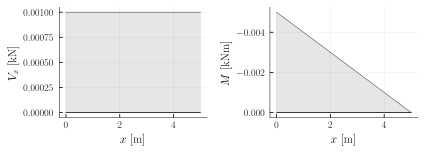

In [10]:
#| label: fig-sk-kragarm-virtuell
#| fig-cap: "Schnittkräfte des virtuellen Systems aus @fig-kragarm-sys-virtuell"

internal_forces_virtual = calc_internal_forces(-1.)

plot_inner_forces(*internal_forces_virtual, x_array, kinematic= False,
                  colors=['black', 'black', 'black', 'black'])

Die @eq-spring_rotation berücksichtigt die zusätzliche Verformung durch die Drehfeder.

$$
w_{Spring} = \bar{M} \frac{M}{k_\varphi} = \bar{M} \varphi
$${#eq-spring_rotation}

Angewendet auf das System der @fig-kragarm-feder folgen für die beiden Laststufen die Deformationen zu:

In [11]:
# Takes the corresponding phi for the middle M
phi_spring_F1 = np.interp(np.median(internal_forces_F1[1]), M_phi_array, Phi_spring_array)
phi_spring_F2 = np.interp(np.median(internal_forces_F2[1]), M_phi_array, Phi_spring_array)

In [12]:
w_spring_F1 = np.median(internal_forces_virtual[1]) * phi_spring_F1
w_spring_F2 = np.median(internal_forces_virtual[1]) * phi_spring_F2


display_eq('w_spring,F1', unit.convert_to(np.round(w_spring_F1,4)*unit.meter, unit.mm))
display_eq('w_spring,F2', unit.convert_to(np.round(w_spring_F2,4)*unit.meter, unit.mm))


w_spring,F1 = 625.0⋅millimeter

w_spring,F2 = 2201.3⋅millimeter

### Vergleich mit FE

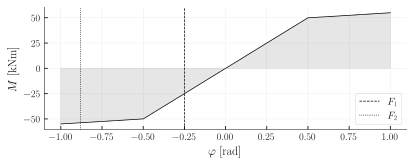

In [13]:
plt.plot(Phi_spring_array, M_phi_array/10**3, color='black')
plt.fill_between(Phi_spring_array, M_phi_array/10**3, color='black', alpha=0.1)

plt.axvline(x=phi_spring_F1, color='black', linestyle='--', label='$F_1$')
plt.axvline(x=phi_spring_F2, color='black', linestyle='dotted', label='$F_2$')


plt.xlabel('$\\varphi$ [rad]')
plt.ylabel('$M$ [kNm]')
plt.legend()
plt.show()

In [14]:
w_tot_F1 = w_spring_F1 + w_bending_F1
display_eq('w_tot,F1', unit.convert_to(np.round(w_tot_F1,5)*unit.meter,unit.mm))



w_tot,F1 = 664.06⋅millimeter

![Verformungen in $z$ Richtung mit FE für $F_2$](../imgs/kragarm_fe_F1.png)

In [15]:
w_tot_F2 = w_spring_F2 + w_bending_F2
display_eq('w_tot,F2', unit.convert_to(np.round(w_tot_F2,5)*unit.meter,unit.mm))

w_tot,F2 = 2285.24⋅millimeter

![Verformungen in $z$ Richtung mit FE für $F_2$](../imgs/kragarm_fe_F2.png)

### Mit Wegfeder

#### Federgesetz

In [16]:
def F_u_spring(M:np.array, Phi:np.array, z:float):
    F = M / z
    u = np.tan(Phi)*z/2

    return F, u

F_array, u_array = F_u_spring(M_phi_array, Phi_spring_array, z)


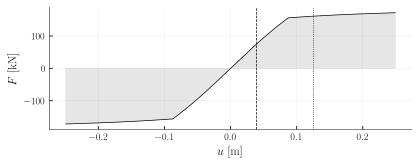

In [17]:


# The deformations for the corresponding F
index_F1 = np.argmin(np.abs(F_array - 75000))
u_F1 = u_array[index_F1]

index_F2 = np.argmin(np.abs(F_array-161.25*1000))
u_F2 = u_array[index_F2]

plt.axvline(x = u_F1, color='black', linestyle='--', label='$F_1$')
plt.axvline(x = u_F2, color='black', linestyle='dotted', label='$F_2$')


plt.plot(u_array, F_array/10**3, color='black')
plt.fill_between(u_array, F_array/10**3, color='black', alpha = 0.1)
plt.xlabel('$u$ [m]')
plt.ylabel('$F$ [kN]')
plt.show()


In [18]:
diff_F = np.gradient(F_array)
diff_u = np.gradient(u_array)
F_of_u_derivative = diff_F/diff_u

k_1_weg = np.max(F_of_u_derivative)
k_2_weg = np.mean(F_of_u_derivative[np.where(F_of_u_derivative <= 500000)])

alpha_weg = k_2_weg / k_1_weg

In [19]:
display_eq('k_1_x', unit.convert_to(np.round(k_1_weg,-2) * unit.N/unit.m, unit.kN))
display_eq('k_2_x', unit.convert_to(np.round(k_2_weg,-2) * unit.N/unit.m, unit.kN))

display_eq('alpha', np.round(alpha_weg,3))

       1953.1⋅kilonewton
k₁ ₓ = ─────────────────
             meter      

       104.0⋅kilonewton
k₂ ₓ = ────────────────
            meter      

α = 0.053

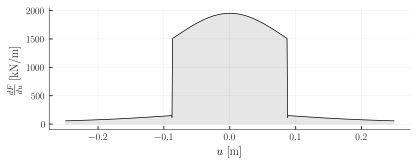

In [20]:
plt.plot(u_array, F_of_u_derivative/10**3, color='black')
plt.fill_between(u_array, F_of_u_derivative/10**3, color='black', alpha = 0.1)
plt.xlabel('$u$ [m]')
plt.ylabel('$\\frac{dF}{du}$ [kN/m]')

plt.show()

In [21]:
index_F_0 = np.max(np.where(np.where(F_of_u_derivative<=500*10**3)[0]<=500))
F_0 = F_array[index_F_0]

display_eq('F_0', unit.convert_to(np.round(F_0, -2)*unit.N, unit.kN))

F₀ = -156.1⋅kilonewton

In [22]:
u_array[index_F_0]

-0.08772059377296854

In [23]:
np.max(u_array)

0.24918523594478437

In [24]:
np.max(F_array)

171702.95295295294

# A3V2

In [25]:
#| label: tbl-parameters-kragarm
#| tbl-cap: "Berechnungsparameter des Versuchs A3V2"

locals().update(params_value_a3v2)

dict_to_table(params_a3v2)


|  Parameter  | ​  |
|---|---|
| $F_{max} = - 320 \text{kN}$ | $l = 2.62 \text{m}$ |
| $l_{spring} = 2.0 \text{mm}$ | ​  |


## Eingabe AxisVM

In [26]:
# Read the text file using numpy
M_array = np.loadtxt('docs/M_A3V2.txt')
chi_array = np.loadtxt('docs/chi_A3V2.txt')

# l_spring = 0.9 #m



array([  0.        ,  25.63386079,  25.63386079, 177.17517476,
       199.84771331])

array([0.00000000e+00, 2.32374725e-06, 7.42601493e-06, 5.13268565e-05,
       1.94727767e-04])

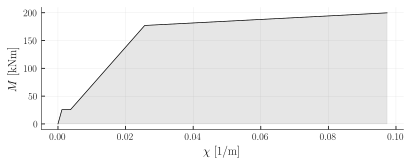

In [27]:
chi_interpolated = np.linspace(0,max(chi_array), 1000)
# Linear interpolation in M_array
M_interpolated = np.interp(chi_interpolated, chi_array, M_array)

# Plot the interpolated data
plt.plot(chi_interpolated, M_interpolated/10**3, color='black')
plt.fill_between(chi_interpolated, M_interpolated/10**3, color='black', alpha=0.1)
plt.xlabel('$\chi$ [1/m]')
plt.ylabel('$M$ [kNm]')
plt.show()


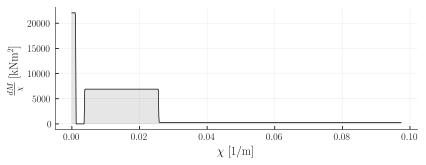

In [28]:
diff_M = np.gradient(M_interpolated)
diff_chi = np.gradient(chi_interpolated)
M_of_chi_derivative = diff_M/diff_chi


plt.plot(chi_interpolated, M_of_chi_derivative/10**3, color='black')
plt.fill_between(chi_interpolated, M_of_chi_derivative/10**3, color='black', alpha = 0.1)
plt.xlabel('$\chi$ [1/m]')
plt.ylabel('$\\frac{dM}{\chi}$ [kNm$^2$]')


plt.show()

In [38]:
fehleranteil = 5 #%

n_spring = (l * fehleranteil/100 / l_spring)
l_element = (l - n_spring * l_spring) / n_spring
l_smeared = l_element / 2 * 2 + l_spring


display(M_array/10**3, chi_array * l_smeared)

array([  0.        ,  25.63386079,  25.63386079, 177.17517476,
       199.84771331])

array([0.00000000e+00, 4.64749449e-05, 1.48520299e-04, 1.02653713e-03,
       3.89455535e-03])

In [40]:
204/194.5

1.0488431876606683